In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import matplotlib.style
import matplotlib as mpl
import scipy
from scipy.optimize import curve_fit

def reject_outliers(data, m=5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return np.array(data)[s < m]

def fun(x, a, c, e0):
    if abs(a - 1.) < 1e-15:
        p = x
    else:
        p = (1. - pow(a, x)) / (1. - a)
    return pow(c, p) * pow(e0, pow(a, x))

def parse_file(filepath):
    err_data = []
    with open(filepath, "r") as log_file:
        iter_err = []
        has_converged = False
        for line in log_file:
            line = line.strip()
            if "SNES Function norm" in line:
                iter_line = line.split()
                iter_err.append(float(iter_line[4]))
            if line.startswith("Nonlinear solve did not converge"):
                has_converged = False
                # iter_err = []
                # continue
            if line.startswith("Nonlinear solve converged"):                
                err_data.append(iter_err)
                iter_err = []
    return err_data

def get_conv_order(err_data, lim=3, use_fit=False, plot_err=False):
    order_list = []
    plt.figure(2)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for err in err_data:
        if len(err) < lim:
            continue
        if len(err) > lim:
            err_lim = err[len(err)-lim:len(err)]
        else:
            err_lim = err
        if use_fit:
            it = np.arange(len(err_lim))
            sigma = [1e32, 1e16, 1e8, 1e4, 1]
            if len(sigma) > len(err_lim):
                sigma_lim = sigma[len(sigma)-len(err_lim):len(sigma)]
            else:
                sigma_lim = sigma
            try:
                popt, pcov = curve_fit(fun, it, err_lim, maxfev = 1000000, sigma=sigma_lim)
                order_list.append(popt[0])
                if plot_err:
                    plt.plot(it, np.log10(err_lim), marker = 'o', c=colors[0])
                    plt.plot(it, np.log10(fun(it, popt[0], popt[1], popt[2])), ls = '--', c=colors[1], label = "a = {:4.2f}".format(popt[0]))
            except RuntimeError as e: 
                print(e)
        else:
            if len(err_lim) < 3:
                continue
            e_next = err_lim[2] / err_lim[1]
            e_prev = err_lim[1] / err_lim[0]
            order_list.append(np.log(e_next) / np.log(e_prev))
    return reject_outliers(order_list)


def plotting(data_list, colors, labels):
    plt.figure(1)
    max_step_num = 0
    for data, c, lab in zip(data_list, colors, labels):
        if len(data) > max_step_num:
            max_step_num = len(data)
        plt.plot(data, color=c, marker='o',label=lab)
    for data, c, lab in zip(data_list, colors, labels):
        rate_mean = np.mean(data)
        plt.plot(np.arange(max_step_num), np.ones(max_step_num)*rate_mean, color=c, ls='--', lw = 2, label=None)
    plt.plot(np.arange(max_step_num), np.ones(max_step_num)*2, color='k', ls=':', lw = 1, label=None)
    plt.legend()
    plt.savefig('convergence_order.png')


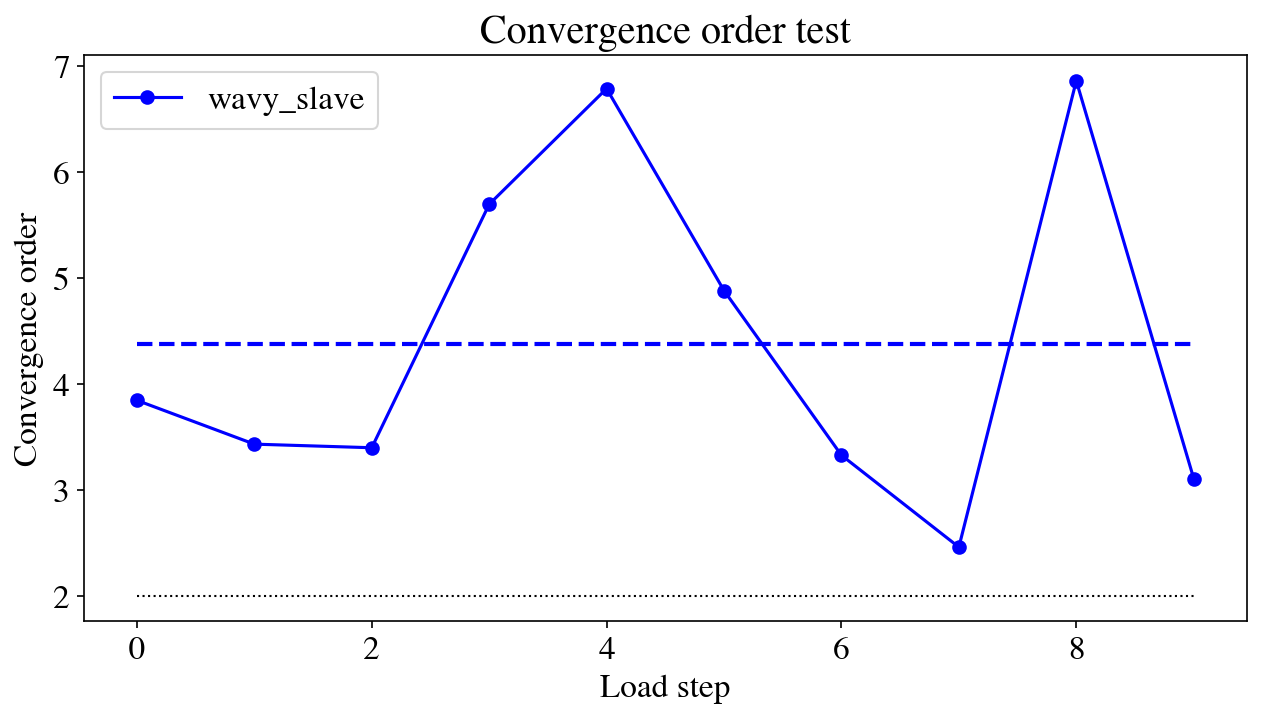

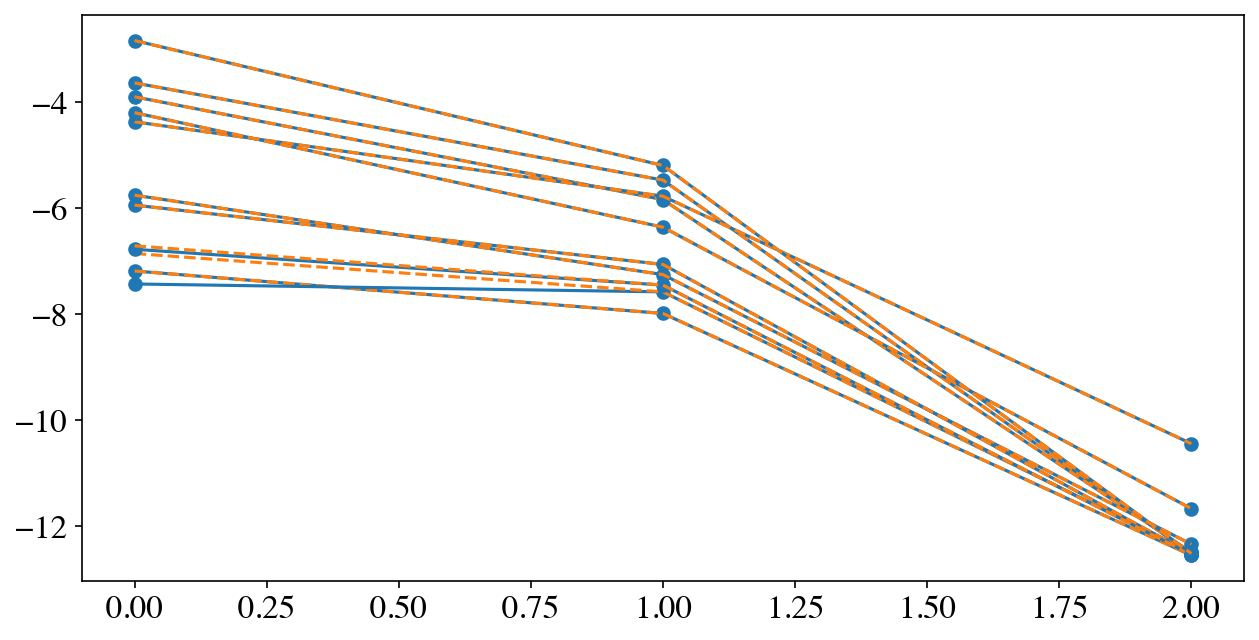

In [7]:
if __name__ == '__main__':
    
    # files = ["/Users/ashvarts/Tests/fracture/wedge_test/new_cut/press_ale/log", "/Users/ashvarts/Tests/fracture/wedge_test/new_cut/press_ale/log_1", 
    
    files = ["/Users/ashvarts/mofem_install/um_release/build/extended_contact/test/log_slave"]
    colors = ['b', 'r', 'g', 'b', 'm']
    labels = ["wavy_slave", "wavy_master"]

    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['font.family'] = "Times"
    plt.rcParams['font.size'] = 16

    plt.figure(1)
    plt.title("Convergence order test")
    plt.ylabel("Convergence order")
    plt.xlabel("Load step")

    # plt.figure(2)
    # plt.title("Convergence plots")
    # plt.ylabel("Residual norm")
    # plt.xlabel("Iteration")

    data_list = []
    for file in files:
        data = parse_file(file)
        data_list.append(get_conv_order(data, use_fit=True, plot_err=True))
   
    plotting(data_list, colors, labels)   
    plt.show()


alpha: [0.8579270489945379, 0.34667020579877644, 4.648947165687296]


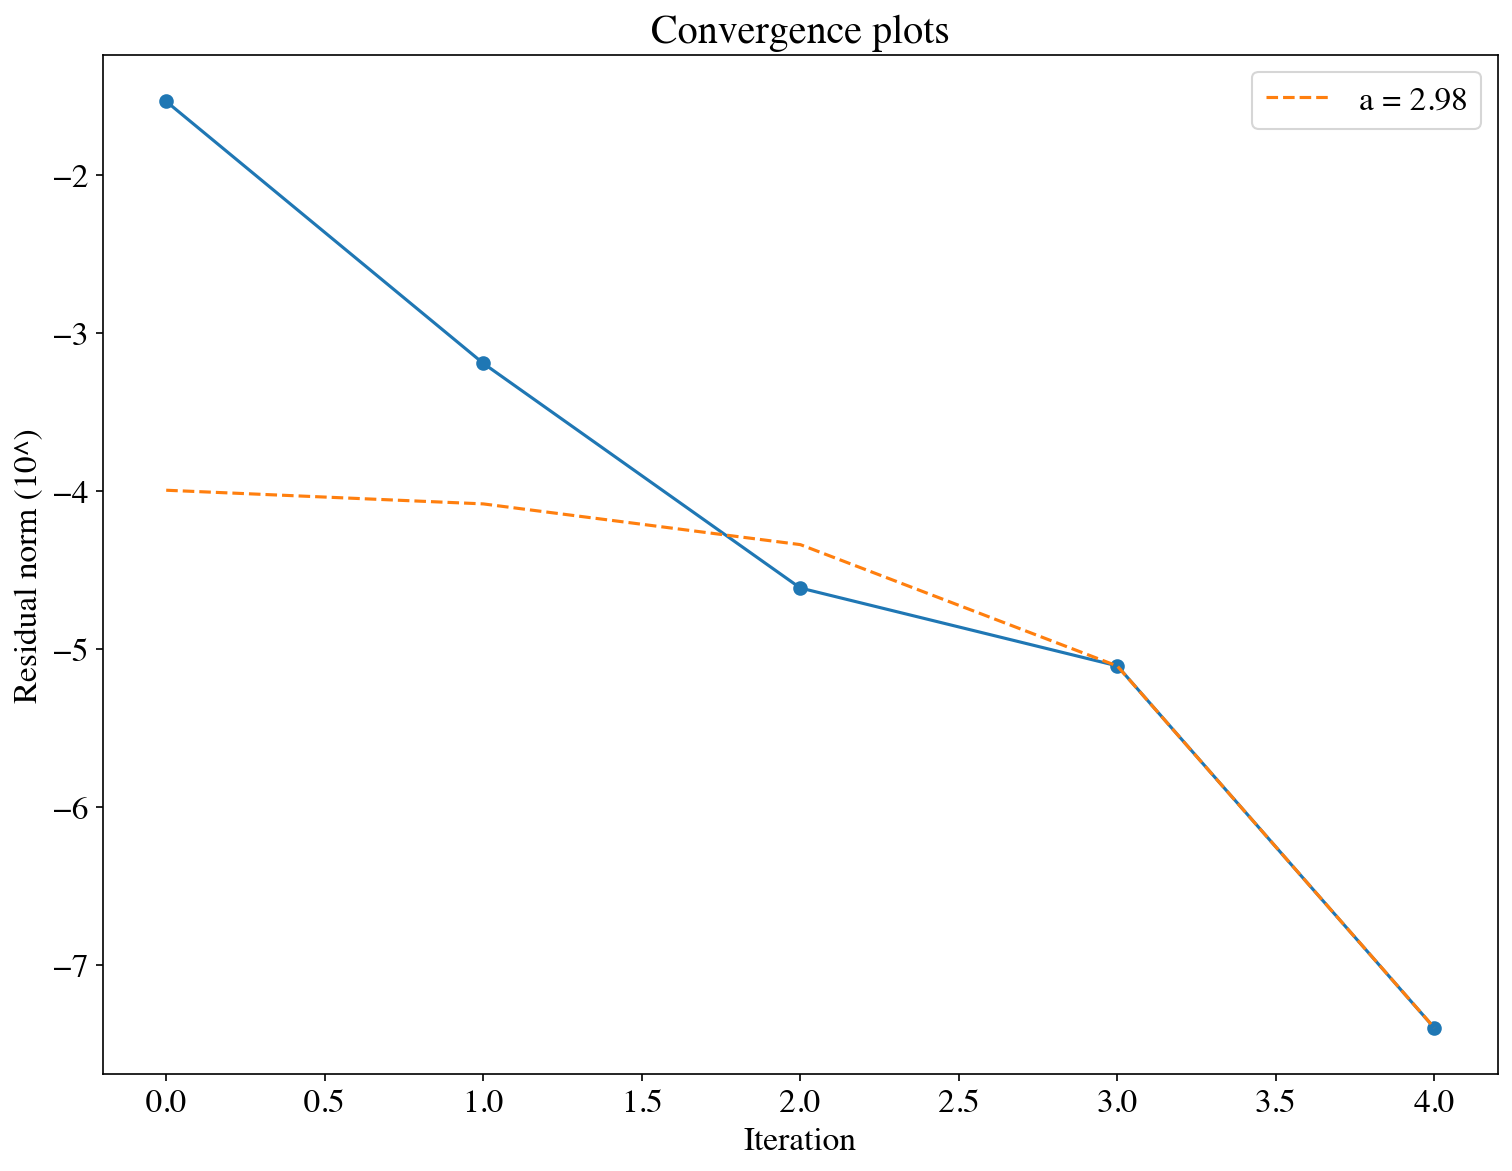

In [28]:
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = "Times"
plt.rcParams['font.size'] = 16

data = [[6.587544062410e-04 , 9.103006462439e-06 , 3.632291284090e-08]]
ord = get_conv_order(data, use_fit=True, lim=5, plot_err=True)
l = plt.legend()
plt.title("Convergence plots")
plt.ylabel("Residual norm (10^)")
plt.xlabel("Iteration")

for d in data:
    rate = []
    for i in np.arange(1, len(d)-1):
        e_next = d[i+1] / d[i]
        e_prev = d[i] / d[i-1]
        rate.append(np.log(e_next) / np.log(e_prev))
    print("alpha:", rate)

